In [1]:
from __future__ import print_function, division
%pylab inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from bokeh.plotting import *

from bokeh.io import output_notebook
output_notebook()
from collections import Counter
from operator import itemgetter

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
df = pd.read_pickle('clf.df')

In [3]:
print(df.columns)
df.head(2)

Index([u'idx', u'jdx', u'vec-diff', u'cos-sim', u'euc-dist', u'man-dist',
       u'bin_diff', u'max_diff', u'mean_diff', u'median_diff', u'v1_max',
       u'v2_max', u'v1_min', u'v2_min', u'v1_mean', u'v2_mean', u'v1_median',
       u'v2_median', u'v1', u'v2', u'c1', u'c2', u'c_id', u'prereq_id',
       u'ground-truth'],
      dtype='object')


,idx,jdx,vec-diff,cos-sim,euc-dist,man-dist,bin_diff,max_diff,mean_diff,median_diff,...,v2_mean,v1_median,v2_median,v1,v2,c1,c2,c_id,prereq_id,ground-truth
16537,128,25,17.748784,0.003202,1.411948,21.752792,2743,0.31372,0.001234,0.0,...,0.001375,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.00162287432229, 0.0, 0.0, 0.0, 0....",Learn Backbone.js,Intro to Psychology,ud990,ps001,False
5701,44,25,17.380557,0.001237,1.413338,22.088425,2738,0.31372,0.001209,0.0,...,0.001375,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.00162287432229, 0.0, 0.0, 0.0, 0....",Intro to jQuery,Intro to Psychology,ud245,ps001,False


In [4]:
features = ['v1', 'v2']
target = 'ground-truth'
print(features)
print(target)
print('unused:', set(df.columns) - set(features) - set([target]))

['v1', 'v2']
ground-truth
unused: set(['mean_diff', 'c_id', 'bin_diff', 'median_diff', 'prereq_id', 'v2_min', 'max_diff', 'v2_max', 'vec-diff', 'v1_median', 'man-dist', 'v1_max', 'cos-sim', 'c2', 'c1', 'v2_mean', 'idx', 'v2_median', 'euc-dist', 'v1_mean', 'v1_min', 'jdx'])


In [105]:
pos_weight = 1. / df[target].sum() * 1000
neg_weight = 1. / (len(df) - df[target].sum()) * 1000
df['w'] = df[target].apply(lambda x: pos_weight if x > 0 else neg_weight)

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
import random
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2, activity_l2, activity_l1, l1l2, l1
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.layers.core import Flatten
import copy

In [115]:
def gen_nn(input_shape, hidden_layers):
    print('gen conv nn...')
    num_features = len(features)
    print('num features', num_features)
    # number of convolutional filters to use
    nb_filters = 64
    # size of pooling area for max pooling
    nb_pool = (2, 1)
    # convolution kernel size
    nb_conv_row = 3
    nb_conv_col = 2
    output_activation = 'sigmoid'
    model = Sequential()
    model.add(Convolution2D(nb_filters, nb_conv_row, nb_conv_col,
                            border_mode='same',
                            input_shape=input_shape[1:]))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, nb_conv_row, nb_conv_col))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=nb_pool))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, **dense_kwargs))
    model.add(Activation(output_activation))
    #model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-06), loss='binary_crossentropy', metrics=['accuracy']) #binary_crossentropy, mse
    #model.compile(optimizer='adadelta', loss='mse', metrics=['accuracy'])
    model.compile(optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    print('output size:', 1, output_activation)
    print('done')
    return model

def model_acc(nn, X, y_true, weights, th=.5):
    y_pred = nn.predict(X)
    print('max', y_pred.max())
    print('min', y_pred.min())
    y_pred = y_pred > th
    return accuracy_score(y_true, y_pred, normalize=True, sample_weight=weights)

In [116]:
epochs = 5
batch_size = 30
dense_kwargs = dict()
dense_kwargs["init"] = 'uniform'

  0%|          | 0/10 [00:00<?, ?it/s]

(14976, 1, 14378, 2)
(1665, 1, 14378, 2)
gen conv nn...
num features 2
output size: 1 sigmoid
done
fit
Train on 14976 samples, validate on 1665 samples
Epoch 1/5
14976/14976 [==============================] - 3029s - loss: 0.0870 - acc: 0.4288 - val_loss: 0.7265 - val_acc: 0.0072
Epoch 2/5
14976/14976 [==============================] - 3320s - loss: 0.0845 - acc: 0.3652 - val_loss: 0.5820 - val_acc: 0.9928
Epoch 3/5
14976/14976 [==============================] - 3557s - loss: 0.0837 - acc: 0.5019 - val_loss: 0.5552 - val_acc: 0.9928
Epoch 4/5
14976/14976 [==============================] - 3576s - loss: 0.0847 - acc: 0.4844 - val_loss: 0.5878 - val_acc: 0.9928
Epoch 5/5
14976/14976 [==============================] - 3598s - loss: 0.0847 - acc: 0.5098 - val_loss: 0.7625 - val_acc: 0.0072
['v1', 'v2']


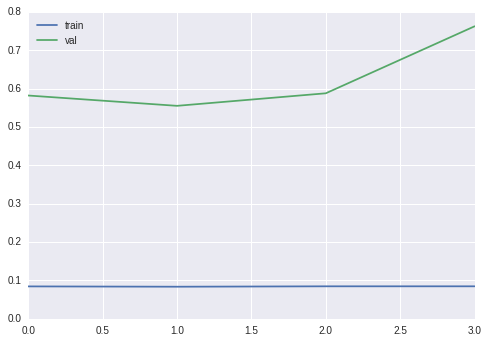

max 0.53395
min 0.533946


 10%|█         | 1/10 [5:08:30<46:16:35, 18510.58s/it]

max 0.533949
min 0.533946
[('train', 0.49879606971045021), ('test', 0.51057782171794019)]
(14976, 1, 14378, 2)
(1665, 1, 14378, 2)
gen conv nn...
num features 2
output size: 1 sigmoid
done
fit
Train on 14976 samples, validate on 1665 samples
Epoch 1/5
14976/14976 [==============================] - 3062s - loss: 0.0847 - acc: 0.5229 - val_loss: 0.6011 - val_acc: 0.9928
Epoch 2/5
14976/14976 [==============================] - 3348s - loss: 0.0838 - acc: 0.5614 - val_loss: 0.5985 - val_acc: 0.9928
Epoch 3/5
14976/14976 [==============================] - 3463s - loss: 0.0831 - acc: 0.5560 - val_loss: 0.6221 - val_acc: 0.9928
Epoch 4/5
14976/14976 [==============================] - 3471s - loss: 0.0842 - acc: 0.5488 - val_loss: 0.7554 - val_acc: 0.0072
Epoch 5/5
14976/14976 [==============================] - 3449s - loss: 0.0848 - acc: 0.4549 - val_loss: 0.6952 - val_acc: 0.0072
['v1', 'v2']


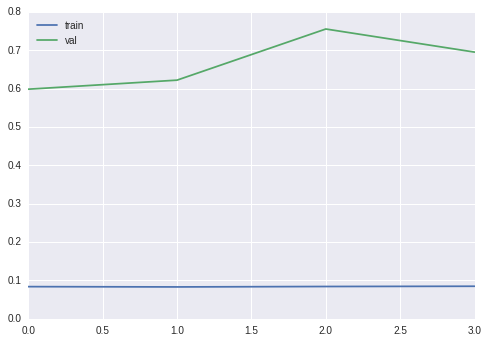

max 0.501032
min 0.501027


 20%|██        | 2/10 [10:10:27<40:52:20, 18392.58s/it]

max 0.501031
min 0.501027
[('train', 0.49879606971045021), ('test', 0.51057782171794019), ('train', 0.4987960697104501), ('test', 0.51057782171794019)]
(14976, 1, 14378, 2)
(1665, 1, 14378, 2)
gen conv nn...
num features 2
output size: 1 sigmoid
done
fit
Train on 14976 samples, validate on 1665 samples
Epoch 1/5
14976/14976 [==============================] - 2964s - loss: 0.0857 - acc: 0.5165 - val_loss: 0.5240 - val_acc: 0.9928
Epoch 2/5
14976/14976 [==============================] - 3256s - loss: 0.0844 - acc: 0.5568 - val_loss: 0.7349 - val_acc: 0.0072
Epoch 3/5
14976/14976 [==============================] - 3477s - loss: 0.0846 - acc: 0.4358 - val_loss: 0.8593 - val_acc: 0.0072
Epoch 4/5
14976/14976 [==============================] - 3490s - loss: 0.0845 - acc: 0.3833 - val_loss: 0.6935 - val_acc: 0.0072
Epoch 5/5
14976/14976 [==============================] - 3449s - loss: 0.0847 - acc: 0.5652 - val_loss: 1.0014 - val_acc: 0.0072
['v1', 'v2']


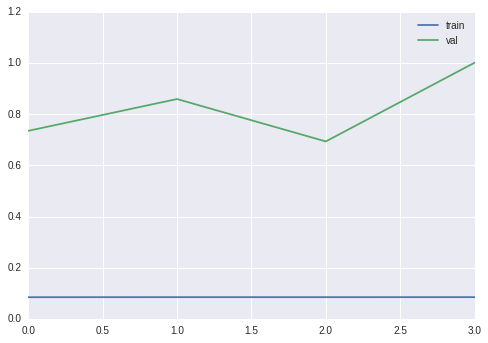

KeyboardInterrupt: 

In [117]:
r = list()
train_test_split = StratifiedShuffleSplit(df[target], train_size=.9)
for train_idx, test_idx in tqdm(train_test_split):
    train = df.iloc[train_idx].copy()
    train_y = train[target].values
    train_w = train['w'].values
    tmp = list()
    for v1, v2 in train[features].values:
        tmp.append(np.vstack([v1, v2]).T.reshape(1, len(v1), 2))
    train = np.array(tmp)
    
    test = df.iloc[test_idx].copy()
    test_y = test[target].values
    test_w = test['w'].values
    tmp = list()
    for v1, v2 in test[features].values:
        tmp.append(np.vstack([v1, v2]).T.reshape(1, len(v1), 2))
    test = np.array(tmp)
    del tmp
    
    print(train.shape)
    print(test.shape)
    
    input_shape = train.shape
    
    nn = gen_nn(input_shape, hidden_layers)
    print('fit')
    hist = nn.fit(train, train_y, 
          nb_epoch=epochs, 
          batch_size=batch_size, 
          validation_data=(test, test_y), 
          shuffle=True,
          sample_weight=train_w,
          verbose=1)
    
    print(nn_features)

    data = zip(hist.history['loss'], hist.history['val_loss'])
    hist_df = pd.DataFrame(columns=['train', 'val'], data=data[1:])
    hist_df.plot()
    plt.show()
    #print(train[features])
    
    r.append(('train', model_acc(nn, train, train_y, train_w)))
    r.append(('test', model_acc(nn, test, test_y, test_w)))
    print(r)

r = pd.DataFrame(columns=['type', 'mean accuracy'], data=r)
sns.barplot(x='type', y='mean accuracy', data=r)
plt.show()

In [ ]:
print(r)